**`MODELO SVM`**

Primero, importamos las librerías que utilizaremos en este modelo (`SVM`).

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report,roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC

Cargamos la base de datos a la que se le aplicó una técnica de Oversample.

In [49]:
dataNorm = pd.read_csv("../data/Hospitales_Oversample.csv",index_col=0)

Definimos nuestras variables predictoras **X _(features)_** y la etiqueta a predecir **y _(target)_**.

In [50]:
X = dataNorm.drop(columns="HOSPITALIZACION")
Y = dataNorm["HOSPITALIZACION"]

Posteriormente, se separaron los datos de entrenamiento y los datos de prueba, en donde fueron utilizados el `20%` de nuestros datos totales para evaluar el desempeño de modelo en un entorno simulado. Además, se estandarizaron nuestros valores de entrenamiento y testeo.

In [51]:
from sklearn.model_selection import train_test_split
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.2, random_state=0)

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_Train = sc_X.fit_transform(X_Train)
X_Test = sc_X.transform(X_Test)

Realizamos una _`búsqueda exhaustiva`_ para encontrar los mejores hiperparámetros del modelo de clasificación. Utilizaremos la técnica de **_Grid Search Cross-Validation_**, que nos permite explorar diferentes combinaciones de hiperparámetros y evaluar su rendimiento mediante la validación cruzada. 

Nuestro objetivo es encontrar los valores óptimos para los hiperparámetros **`'C','kernel' y 'gamma'`**

In [52]:
classifier = SVC()
rango_hiperparametros = {'C': [0.1, 1, 10],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 
                         'gamma': [0.1, 1, 10]}

modelo =  GridSearchCV(classifier, param_grid = rango_hiperparametros,cv = 5, verbose = True)

modelo.fit(X, Y)

print("Mejores hiperparámetros: "+ str(modelo.best_params_))
print("Mejor Score: "+str(modelo.best_score_)+'\n')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores hiperparámetros: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Mejor Score: 0.8153065630397236



#### Con los resultados de las métricas anteriores,  creamos el modelo de `SVM` con los hiperparametros óptimos, entrenamos el modelo y predecimos la variable objetivo con nuestro set de entrenamiento. 

In [53]:
#Instaciamos el modelo
classifier = SVC (C = 1,gamma=0.1,kernel='linear', probability= True)

#Entrenamos el modelo
classifier.fit(X_Train, Y_Train)

#Predecimos sobre nuestro set de entrenamiento
y_train_pred = classifier.predict(X_Train)
#Predecimos sobre nuestro set de testeo
y_test_pred = classifier.predict(X_Test)

**`Matriz de confusión`**

Fue desarrollado el código para la matriz de confusión de: entrenamiento y testeo, de nuestro modelo.

In [54]:
#Para crear la matriz de confusión
from sklearn.metrics import confusion_matrix

matrix_train = confusion_matrix(Y_Train, y_train_pred)
matrix_test = confusion_matrix(Y_Test, y_test_pred)

#Para visualizar
from sklearn.metrics import ConfusionMatrixDisplay

cm_display_train = ConfusionMatrixDisplay(matrix_train)
cm_display_test = ConfusionMatrixDisplay(matrix_test)

#Para obtener el valor de precisión, recall, F1-score y soporte para cada clase en un problema de clasificación
from sklearn.metrics import classification_report

Visualizamos Matriz de confusión de `Entrenamiento`.

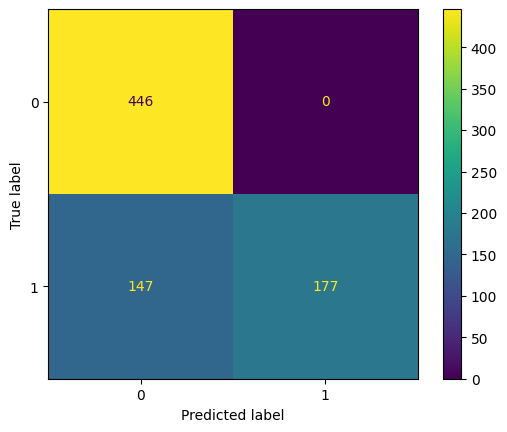

-----------------------------------------------------------------------
                    precision    recall  f1-score   support

           0       0.75      1.00      0.86       446
           1       1.00      0.55      0.71       324

    accuracy                           0.81       770
   macro avg       0.88      0.77      0.78       770
weighted avg       0.86      0.81      0.79       770



In [55]:
cm_display_train.plot()
plt.show()
print(f'''-----------------------------------------------------------------------
      {classification_report(Y_Train, y_train_pred)}''')

Visualizamos Matriz de confusión de `Testeo`.

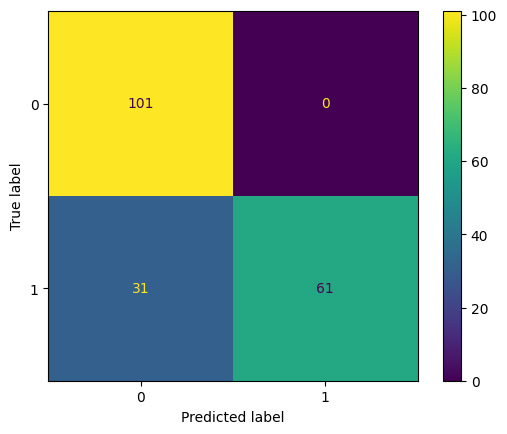

-----------------------------------------------------------------------
                    precision    recall  f1-score   support

           0       0.77      1.00      0.87       101
           1       1.00      0.66      0.80        92

    accuracy                           0.84       193
   macro avg       0.88      0.83      0.83       193
weighted avg       0.88      0.84      0.83       193



In [56]:
cm_display_test.plot()
plt.show()
print(f'''-----------------------------------------------------------------------
      {classification_report(Y_Test, y_test_pred)}''')

#### **`Curvas ROC `**

Por útimo, evaluamos y comparamos los rendimientos del modelo por medio de Curvas de ROC.

In [57]:
from sklearn.preprocessing import label_binarize

# Binarizamos las etiquetas del conjunto de prueba
y_test2 = label_binarize(Y_Test, classes=[0,1,2])

# Obtenemos el número de clases presentes en los datos
n_classes = y_test2.shape[1]

# Calculamos las probabilidades de predicción para cada clase en el conjunto de prueba
y_score = classifier.predict_proba(X_Test)

Calculamos las tasas de falsos positivos (FPR), las tasas de verdaderos positivos (TPR) y el AUC para cada clase en comparación con el resto de las clases.

In [58]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes-1):
    fpr[i], tpr[i], _ = roc_curve(y_test2[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

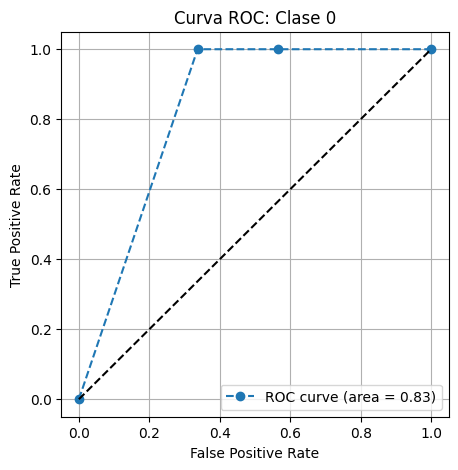

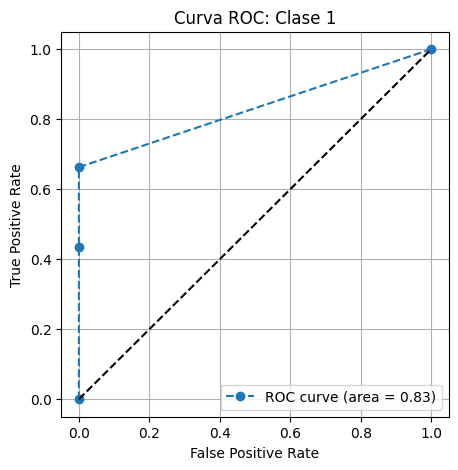

In [59]:
#Recorremos con un bucle cada una de las clases
for i in range(n_classes-1):
    plt.figure(figsize=(5,5))
    plt.plot(fpr[i], tpr[i],'o--', label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC: Clase ' + str(i))
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()